# Some regularizations on [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
By [Zahra Taheri](https://github.com/zahta), November 5, 2020

### Preperation for Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#unzip dataset files from google drive to content folder in colab

import os

if os.path.exists("/content/cifar-100-python/")==False:
    print("unzip files!")
    !unzip -q "/content/drive/My Drive/cifar-100.zip"

### Import libraries

In [3]:
import numpy as np

import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

import os

np.random.seed(100)

## Loading CIFAR-100

In [4]:
def get_proper_images(raw):
    raw_float = np.array(raw, dtype=float) 
    images = raw_float.reshape([-1, 3, 32, 32])
    images = images.transpose([0, 2, 3, 1])
    return images.astype(int)

#def onehot_labels(labels):
#    return np.eye(100)[labels]

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train_data=get_proper_images(unpickle('cifar-100-python/train')[b'data'])
#train_labels=onehot_labels(unpickle('cifar-100-python/train')[b'fine_labels'])
train_labels=unpickle('cifar-100-python/train')[b'fine_labels']
test_data=get_proper_images(unpickle('cifar-100-python/test')[b'data'])
#test_labels=onehot_labels(unpickle('cifar-100-python/test')[b'fine_labels'])
test_labels=unpickle('cifar-100-python/test')[b'fine_labels']

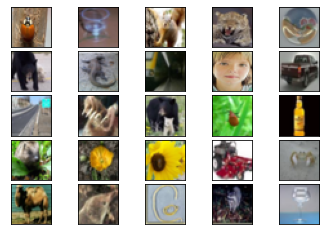

In [6]:
# display some random training images in a grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

## Preparation of the dataset

In [7]:
#some_digit = train_data[0]
#some_digit_image = some_digit
#plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
#plt.axis("off")
#plt.show()

In [8]:
#nsamples, a,b,c = train_data.shape
#print(train_data.shape)
#X_train= train_data.reshape((nsamples,a*b*c))
#nsamples2, a2,b2,c2 = test_data.shape
#X_test= test_data.reshape((nsamples2,a2*b2*c2))


#from sklearn import preprocessing

#scale = preprocessing.MinMaxScaler()
#X_train = scale.fit_transform(X_train)
#X_test = scale.fit_transform(X_test)
#print(X_train.shape)

#train_data= X_train.reshape((nsamples, a,b,c))
#test_data= X_test.reshape((nsamples2, a2,b2,c2))
#print(train_data.shape)

In [9]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [10]:
tensor_x2 = torch.Tensor(test_data) # transform to torch tensor
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2) # create your datset

In [11]:
tensor_y

tensor([19, 29,  0,  ...,  3,  7, 73])

## Building Feedforward Neural Networks with PyTorch

In [12]:
# import libraries
import torch
import torch.nn as nn

from torch.autograd import Variable
from torchsummary import summary

## L2 regularization

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [13]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [15]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [16]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [17]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5               [-1, 1, 512]         768,512
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 32.79
Estimated Total Size (MB): 32.86
----------------------------------------------------------------


In [18]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L2 regularization

In [19]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 4.136871337890625. Accuracy: 11
Iteration: 1000. Loss: 3.552062749862671. Accuracy: 15
Iteration: 1500. Loss: 3.519686698913574. Accuracy: 16
Iteration: 2000. Loss: 3.2725186347961426. Accuracy: 17
Iteration: 2500. Loss: 3.174743890762329. Accuracy: 18
Iteration: 3000. Loss: 3.3436739444732666. Accuracy: 19
Iteration: 3500. Loss: 3.1570584774017334. Accuracy: 19
Iteration: 4000. Loss: 3.183466911315918. Accuracy: 20
Iteration: 4500. Loss: 2.9578914642333984. Accuracy: 21
Iteration: 5000. Loss: 3.0302631855010986. Accuracy: 22
Iteration: 5500. Loss: 3.000495433807373. Accuracy: 21
Iteration: 6000. Loss: 2.875300884246826. Accuracy: 22
Iteration: 6500. Loss: 3.098328113555908. Accuracy: 23
Iteration: 7000. Loss: 2.8860855102539062. Accuracy: 23
Iteration: 7500. Loss: 2.8006062507629395. Accuracy: 22
Iteration: 8000. Loss: 2.942256450653076. Accuracy: 24
Iteration: 8500. Loss: 2.6757447719573975. Accuracy: 24
Iteration: 9000. Loss: 2.4672694206237793. Accuracy: 24
It

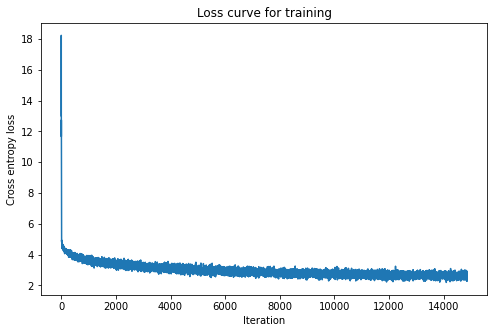

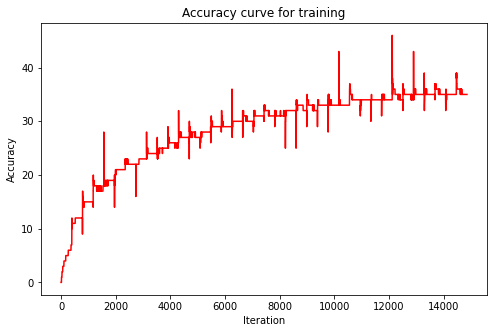

In [20]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [21]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_A_l2.pkl')# only save parameters

### Model B: 7 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [22]:
batch_size = 128
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

76


In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [24]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        # non-linearity 4
        self.relu4 = nn.ReLU()
        
        # linear function 5
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        # non-linearity 5
        self.relu5 = nn.ReLU()

        # linear function 6
        self.fc6 = nn.Linear(hidden_dim5, hidden_dim6)
        # non-linearity 6
        self.relu6 = nn.ReLU()
        
        # linear function 7
        self.fc7 = nn.Linear(hidden_dim6, hidden_dim7)
        # non-linearity 7
        self.relu7 = nn.ReLU()
        
        # linear function 8 (readout)
        self.fc8 = nn.Linear(hidden_dim7, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        # linear function 4
        out = self.fc4(out)
        # non-linearity 4
        out = self.relu4(out)
        
        # linear function 5
        out = self.fc5(out)
        # non-linearity 5
        out = self.relu5(out)

        # linear function 6
        out = self.fc6(out)
        # non-linearity 6
        out = self.relu6(out)
        
        # linear function 7
        out = self.fc7(out)
        # non-linearity 7
        out = self.relu7(out)
        
        #linear function 8 (readout)
        out = self.fc8(out)
        return out       
    

In [25]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 1024
hidden_dim4 = 512
hidden_dim5 = 200
hidden_dim6 = 200
hidden_dim7 = 200

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [26]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5              [-1, 1, 1024]       1,537,024
              ReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 512]         524,800
              ReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 200]         102,600
             ReLU-10               [-1, 1, 200]               0
           Linear-11               [-1, 1, 200]          40,200
             ReLU-12               [-1, 1, 200]               0
           Linear-13               [-1, 1, 200]          40,200
             ReLU-14               [-1,

In [27]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.01
LAMBDA = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.9)

#### Train the model with L2 regularization

In [28]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 3.983077049255371. Accuracy: 7
Iteration: 1000. Loss: 3.849010467529297. Accuracy: 10
Iteration: 1500. Loss: 3.7062926292419434. Accuracy: 12
Iteration: 2000. Loss: 3.6394381523132324. Accuracy: 14
Iteration: 2500. Loss: 3.368581533432007. Accuracy: 16
Iteration: 3000. Loss: 3.365874767303467. Accuracy: 16
Iteration: 3500. Loss: 3.285417079925537. Accuracy: 18
Iteration: 4000. Loss: 3.250066041946411. Accuracy: 16
Iteration: 4500. Loss: 3.3861095905303955. Accuracy: 19
Iteration: 5000. Loss: 3.0012309551239014. Accuracy: 18
Iteration: 5500. Loss: 3.1752331256866455. Accuracy: 19
Iteration: 6000. Loss: 3.2419512271881104. Accuracy: 19
Iteration: 6500. Loss: 3.11391282081604. Accuracy: 20
Iteration: 7000. Loss: 2.94918155670166. Accuracy: 20
Iteration: 7500. Loss: 3.266829490661621. Accuracy: 20
Iteration: 8000. Loss: 3.051729917526245. Accuracy: 20
Iteration: 8500. Loss: 2.7437198162078857. Accuracy: 20
Iteration: 9000. Loss: 2.7039148807525635. Accuracy: 22
Iterat

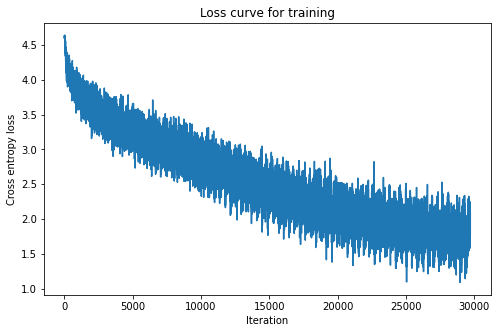

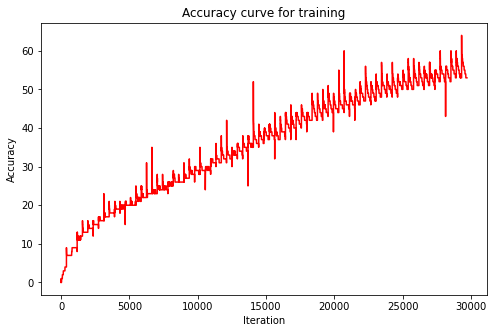

In [29]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [30]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_B_l2.pkl')# only save parameters

## L1 regularization

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [31]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [33]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [34]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [35]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5               [-1, 1, 512]         768,512
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 32.79
Estimated Total Size (MB): 32.86
----------------------------------------------------------------


In [36]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L1 regularization

In [37]:
# Train the model

LAMBDA = 0.001
train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        '''
        L1 regularization
        '''
        l1_regularization = torch.tensor(0).long().cuda()
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).long().cuda()
            
        loss += LAMBDA * l1_regularization
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 92.95142364501953. Accuracy: 11
Iteration: 1000. Loss: 92.50951385498047. Accuracy: 15
Iteration: 1500. Loss: 92.38949584960938. Accuracy: 16
Iteration: 2000. Loss: 92.2889175415039. Accuracy: 18
Iteration: 2500. Loss: 92.15730285644531. Accuracy: 18
Iteration: 3000. Loss: 91.94597625732422. Accuracy: 19
Iteration: 3500. Loss: 92.22028350830078. Accuracy: 20
Iteration: 4000. Loss: 91.72747802734375. Accuracy: 20
Iteration: 4500. Loss: 91.77699279785156. Accuracy: 21
Iteration: 5000. Loss: 91.49483489990234. Accuracy: 21
Iteration: 5500. Loss: 91.79112243652344. Accuracy: 21
Iteration: 6000. Loss: 91.51260375976562. Accuracy: 22
Iteration: 6500. Loss: 91.53236389160156. Accuracy: 22
Iteration: 7000. Loss: 91.36090087890625. Accuracy: 23
Iteration: 7500. Loss: 91.24195098876953. Accuracy: 23
Iteration: 8000. Loss: 91.25398254394531. Accuracy: 23
Iteration: 8500. Loss: 90.90940856933594. Accuracy: 24
Iteration: 9000. Loss: 91.0051040649414. Accuracy: 23
Iteration: 95

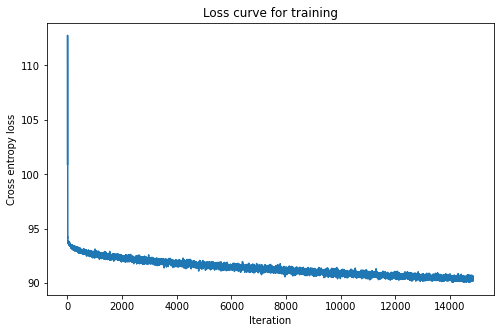

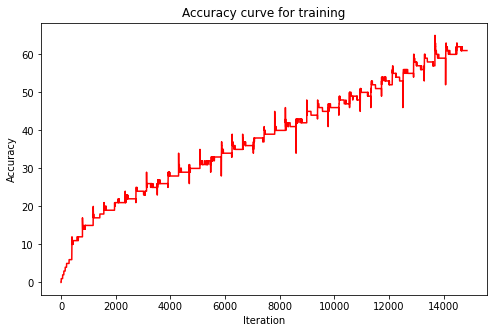

In [38]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [39]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_A_l1.pkl')# only save parameters

### Model B: 7 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [40]:
batch_size = 128
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

76


In [41]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [42]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        # non-linearity 4
        self.relu4 = nn.ReLU()
        
        # linear function 5
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        # non-linearity 5
        self.relu5 = nn.ReLU()

        # linear function 6
        self.fc6 = nn.Linear(hidden_dim5, hidden_dim6)
        # non-linearity 6
        self.relu6 = nn.ReLU()
        
        # linear function 7
        self.fc7 = nn.Linear(hidden_dim6, hidden_dim7)
        # non-linearity 7
        self.relu7 = nn.ReLU()
        
        # linear function 8 (readout)
        self.fc8 = nn.Linear(hidden_dim7, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        # linear function 4
        out = self.fc4(out)
        # non-linearity 4
        out = self.relu4(out)
        
        # linear function 5
        out = self.fc5(out)
        # non-linearity 5
        out = self.relu5(out)

        # linear function 6
        out = self.fc6(out)
        # non-linearity 6
        out = self.relu6(out)
        
        # linear function 7
        out = self.fc7(out)
        # non-linearity 7
        out = self.relu7(out)
        
        #linear function 8 (readout)
        out = self.fc8(out)
        return out       
    

In [43]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 1024
hidden_dim4 = 512
hidden_dim5 = 200
hidden_dim6 = 200
hidden_dim7 = 200

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [44]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5              [-1, 1, 1024]       1,537,024
              ReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 512]         524,800
              ReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 200]         102,600
             ReLU-10               [-1, 1, 200]               0
           Linear-11               [-1, 1, 200]          40,200
             ReLU-12               [-1, 1, 200]               0
           Linear-13               [-1, 1, 200]          40,200
             ReLU-14               [-1,

In [45]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model with L1 regularization

In [46]:
# Train the model

LAMBDA = 0.0001
train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        '''
        L1 regularization
        '''
        l1_regularization = torch.tensor(0).long().cuda()
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).long().cuda()
            
        loss += LAMBDA * l1_regularization
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 15.113752365112305. Accuracy: 7
Iteration: 1000. Loss: 15.128944396972656. Accuracy: 12
Iteration: 1500. Loss: 14.827837944030762. Accuracy: 11
Iteration: 2000. Loss: 14.874670028686523. Accuracy: 16
Iteration: 2500. Loss: 14.46043586730957. Accuracy: 15
Iteration: 3000. Loss: 14.564496994018555. Accuracy: 18
Iteration: 3500. Loss: 14.542367935180664. Accuracy: 15
Iteration: 4000. Loss: 14.45033073425293. Accuracy: 19
Iteration: 4500. Loss: 14.420480728149414. Accuracy: 20
Iteration: 5000. Loss: 14.804987907409668. Accuracy: 20
Iteration: 5500. Loss: 14.231002807617188. Accuracy: 22
Iteration: 6000. Loss: 14.106661796569824. Accuracy: 22
Iteration: 6500. Loss: 14.461523056030273. Accuracy: 21
Iteration: 7000. Loss: 14.138397216796875. Accuracy: 23
Iteration: 7500. Loss: 14.125584602355957. Accuracy: 23
Iteration: 8000. Loss: 14.27989673614502. Accuracy: 22
Iteration: 8500. Loss: 13.933979988098145. Accuracy: 23
Iteration: 9000. Loss: 14.333961486816406. Accuracy: 

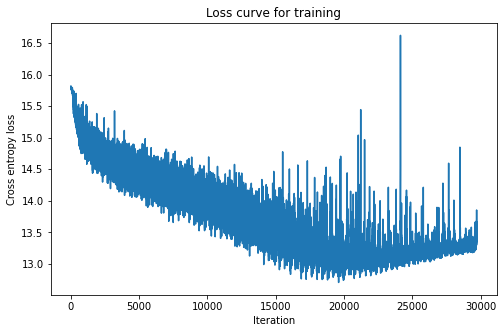

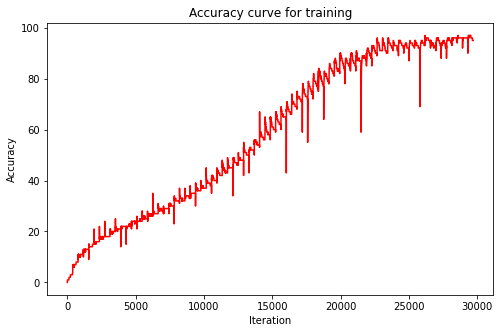

In [47]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [48]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_B_l1.pkl')# only save parameters

##  Data Augmentation

It must be noted that by using the dataset that was loaded manually and because of the large size of the training set, I encontered some problems with data augmentation, e.g., program execution speed after preparing the data for augmentation.

So, for this part, intentionally, I have loaded the dataset from the library. 

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL


train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomRotation(degrees=50),
    transforms.RandomCrop(size=(10, 10)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    #transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2),
    #                                    resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


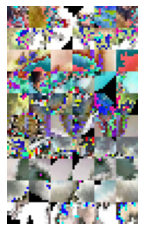

In [50]:
def show_dataset(dataset, n=6):
        img = np.vstack((np.hstack((np.asarray(transforms.functional.to_pil_image(dataset[i][0])) for _ in range(n)))
                   for i in range(10)))
        plt.imshow(img)
        plt.axis('off')
        
show_dataset(trainset)

### Model A: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [51]:
batch_size = 128
n_iters = 15000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [52]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Create model class

In [53]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [54]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [55]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5               [-1, 1, 512]         768,512
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 100]          51,300
Total params: 8,595,412
Trainable params: 8,595,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 32.79
Estimated Total Size (MB): 32.86
----------------------------------------------------------------


In [56]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [57]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 3.856934070587158. Accuracy: 11
Iteration: 1000. Loss: 3.8633408546447754. Accuracy: 15
Iteration: 1500. Loss: 3.4174916744232178. Accuracy: 16
Iteration: 2000. Loss: 3.2891664505004883. Accuracy: 17
Iteration: 2500. Loss: 3.0914499759674072. Accuracy: 18
Iteration: 3000. Loss: 3.0131449699401855. Accuracy: 19
Iteration: 3500. Loss: 3.166513442993164. Accuracy: 20
Iteration: 4000. Loss: 2.73012375831604. Accuracy: 20
Iteration: 4500. Loss: 2.9511053562164307. Accuracy: 21
Iteration: 5000. Loss: 2.745042324066162. Accuracy: 21
Iteration: 5500. Loss: 2.5806424617767334. Accuracy: 21
Iteration: 6000. Loss: 2.593029022216797. Accuracy: 22
Iteration: 6500. Loss: 2.5779271125793457. Accuracy: 22
Iteration: 7000. Loss: 2.5261049270629883. Accuracy: 22
Iteration: 7500. Loss: 2.436365842819214. Accuracy: 23
Iteration: 8000. Loss: 2.536548376083374. Accuracy: 22
Iteration: 8500. Loss: 2.435779333114624. Accuracy: 23
Iteration: 9000. Loss: 2.2893965244293213. Accuracy: 23
It

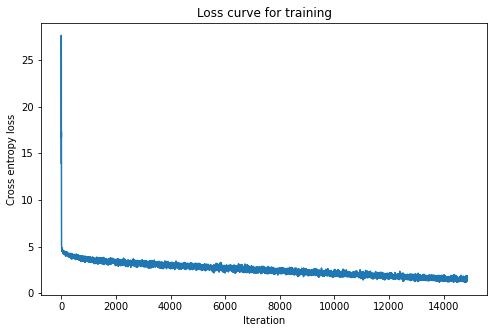

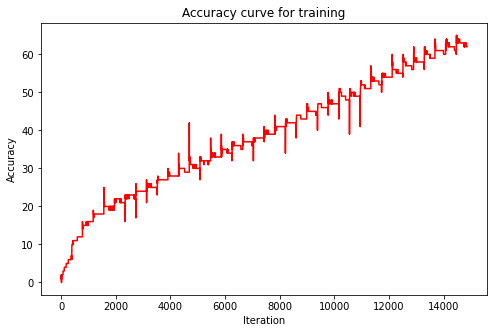

In [58]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [59]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_A_aug.pkl')# only save parameters

### Model B: 7 Hidden Layers Feedforward Neural Network

In [60]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomRotation(degrees=70),
    #transforms.RandomCrop(size=(30, 30)),
    transforms.ColorJitter(hue=.02, saturation=.05),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    #transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2),
    #                                    resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


#### Make dataset iterable

In [61]:
batch_size = 128
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

76


In [62]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Create model class

In [63]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        # non-linearity 4
        self.relu4 = nn.ReLU()
        
        # linear function 5
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        # non-linearity 5
        self.relu5 = nn.ReLU()

        # linear function 6
        self.fc6 = nn.Linear(hidden_dim5, hidden_dim6)
        # non-linearity 6
        self.relu6 = nn.ReLU()
        
        # linear function 7
        self.fc7 = nn.Linear(hidden_dim6, hidden_dim7)
        # non-linearity 7
        self.relu7 = nn.ReLU()
        
        # linear function 8 (readout)
        self.fc8 = nn.Linear(hidden_dim7, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        # linear function 4
        out = self.fc4(out)
        # non-linearity 4
        out = self.relu4(out)
        
        # linear function 5
        out = self.fc5(out)
        # non-linearity 5
        out = self.relu5(out)

        # linear function 6
        out = self.fc6(out)
        # non-linearity 6
        out = self.relu6(out)
        
        # linear function 7
        out = self.fc7(out)
        # non-linearity 7
        out = self.relu7(out)
        
        #linear function 8 (readout)
        out = self.fc8(out)
        return out       
    

In [64]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 100
hidden_dim1 = 1700
hidden_dim2 = 1500
hidden_dim3 = 1024
hidden_dim4 = 512
hidden_dim5 = 200
hidden_dim6 = 200
hidden_dim7 = 200

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [65]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       5,224,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1500]       2,551,500
              ReLU-4              [-1, 1, 1500]               0
            Linear-5              [-1, 1, 1024]       1,537,024
              ReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 512]         524,800
              ReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 200]         102,600
             ReLU-10               [-1, 1, 200]               0
           Linear-11               [-1, 1, 200]          40,200
             ReLU-12               [-1, 1, 200]               0
           Linear-13               [-1, 1, 200]          40,200
             ReLU-14               [-1,

In [66]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.009
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [67]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*32*32).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 3*32*32))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*32*32).cuda())
                else:
                    images = Variable(images.view(-1, 3*32*32))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 4.196545124053955. Accuracy: 6
Iteration: 1000. Loss: 3.7976138591766357. Accuracy: 12
Iteration: 1500. Loss: 3.572634696960449. Accuracy: 14
Iteration: 2000. Loss: 3.446000576019287. Accuracy: 15
Iteration: 2500. Loss: 3.4842944145202637. Accuracy: 17
Iteration: 3000. Loss: 3.6943907737731934. Accuracy: 17
Iteration: 3500. Loss: 3.0219368934631348. Accuracy: 19
Iteration: 4000. Loss: 3.163407802581787. Accuracy: 18
Iteration: 4500. Loss: 3.2073018550872803. Accuracy: 21
Iteration: 5000. Loss: 2.9279656410217285. Accuracy: 20
Iteration: 5500. Loss: 3.0324244499206543. Accuracy: 21
Iteration: 6000. Loss: 2.9362633228302. Accuracy: 21
Iteration: 6500. Loss: 2.9661765098571777. Accuracy: 22
Iteration: 7000. Loss: 3.197080612182617. Accuracy: 21
Iteration: 7500. Loss: 2.7673282623291016. Accuracy: 23
Iteration: 8000. Loss: 2.517817735671997. Accuracy: 24
Iteration: 8500. Loss: 2.4627044200897217. Accuracy: 25
Iteration: 9000. Loss: 2.4080703258514404. Accuracy: 24
Ite

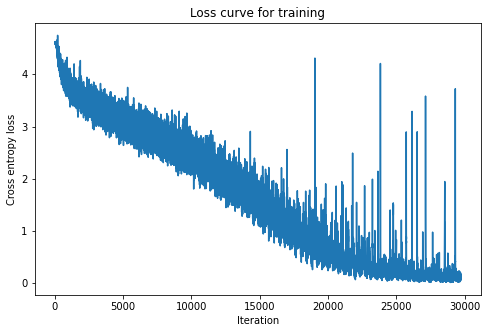

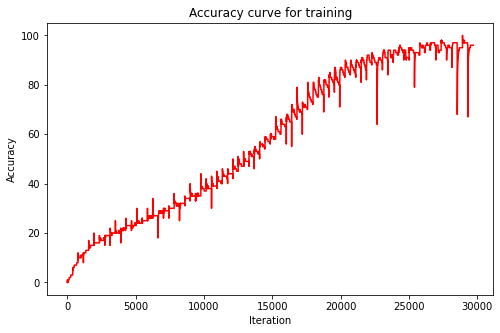

In [68]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [69]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'feedforward_neural_network_pytorch_B_aug.pkl')# only save parameters